In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt  # 新增：可视化库
import seaborn as sns  # 新增：统计可视化库
sns.set(style="whitegrid", font_scale=1.2)  # 新增：设置可视化风格

In [32]:
# 1. 加载数据
file_path = "/Users/Yang/Desktop/BTC_USDT_1h.csv"
df = pd.read_csv(file_path)

# 转换时间戳为datetime并设为索引
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('datetime', inplace=True)

# 原始列：timestamp, datetime, open, high, low, close, volume
features = ['open', 'high', 'low', 'close', 'volume']  # 选择需要生成滞后特征的列

In [33]:
# 新增时间特征
df['hour'] = df.index.hour

# 新增交易量相关特征
df['volume_sma_4'] = df['volume'].rolling(window=4).mean()
df['volume_std_4'] = df['volume'].rolling(window=4).std()

# 更新特征列表
features = features + ['hour', 'volume_sma_4', 'volume_std_4']


In [34]:
# 处理缺失值
df = df.ffill()
df.dropna(inplace=True)

In [35]:
# 标准化数据
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df[features])

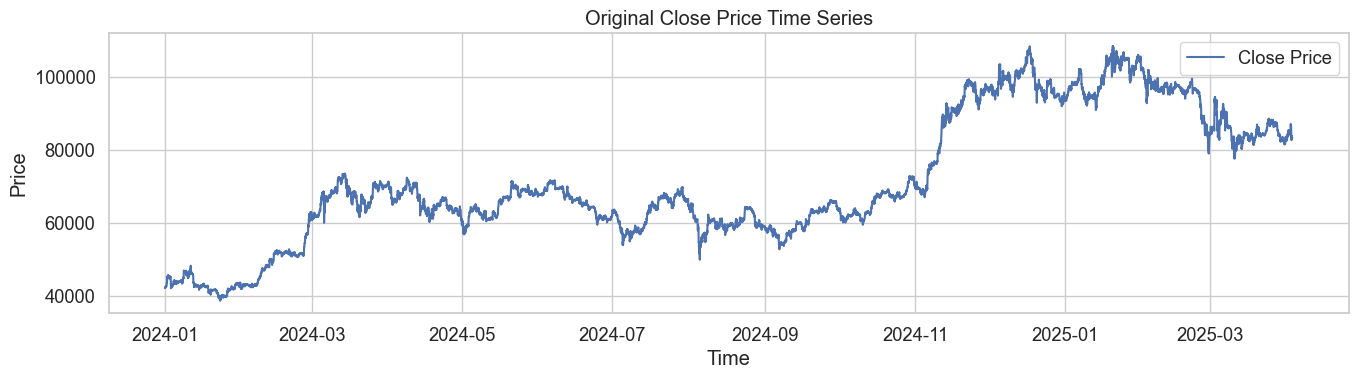

In [36]:
# ====================== 新增内容：特征工程可视化图表 ======================
# ------------------------ 1. 原始时间序列特征可视化 ------------------------
plt.figure(figsize=(16, 8))

# 子图1：收盘价与交易量原始数据
plt.subplot(2, 1, 1)
plt.plot(df['close'], label='Close Price')
plt.title('Original Close Price Time Series')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()


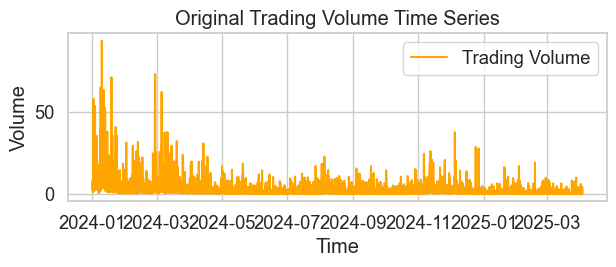

In [37]:
plt.subplot(2, 1, 2)
plt.plot(df['volume'], label='Trading Volume', color='orange')
plt.title('Original Trading Volume Time Series')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()

plt.tight_layout()
plt.show()  # 新增：显示原始时间序列图

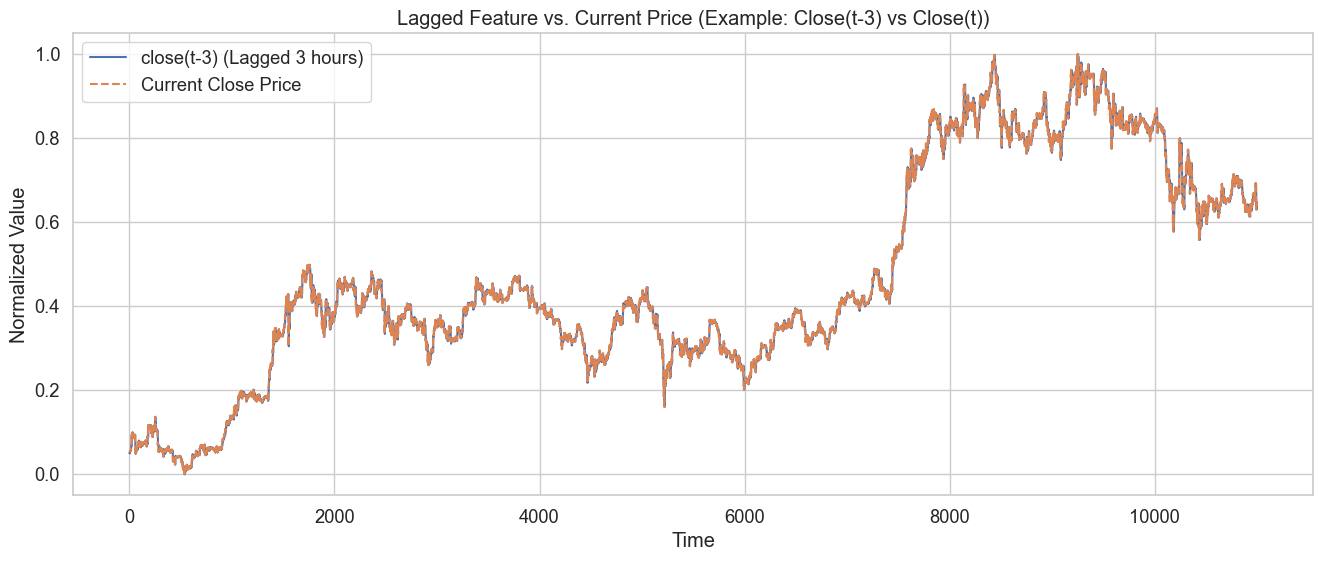

In [38]:
# ------------------------ 2. 滞后特征示例可视化 ------------------------
# 提取滞后特征列（以close(t-3)为例）
lagged_feature = [col for col in reframed.columns if 'close(t-3)' in col][0]

plt.figure(figsize=(16, 6))
plt.plot(reframed.index, reframed[lagged_feature], label=f'{lagged_feature} (Lagged 3 hours)')
plt.plot(reframed.index, reframed['close(t)'], label='Current Close Price', linestyle='--')
plt.title('Lagged Feature vs. Current Price (Example: Close(t-3) vs Close(t))')
plt.xlabel('Time')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()  # 新增：显示滞后特征与当前价格对比


In [41]:
# 生成滞后特征和监督学习格式数据（过去3小时预测未来2小时）
def series_to_supervised(data, features, n_in=3, n_out=2, dropnan=True):
    """
    将时间序列转换为监督学习格式
    :param data: 标准化后的数据（NumPy数组）
    :param features: 原始特征名列表（如 ['open', 'high', 'close', ...]）
    :param n_in: 滞后步数（过去n_in个时间点）
    :param n_out: 预测步数（未来n_out个时间点）
    :param dropnan: 是否删除NaN行
    :return: 包含滞后特征的DataFrame
    """
    n_vars = len(features)
    df = pd.DataFrame(data)
    cols, names = [], []
    
    # 输入序列 (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{features[j]}(t-{i})' for j in range(n_vars)]
    
    # 预测序列 (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{features[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{features[j]}(t+{i})' for j in range(n_vars)]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 生成监督学习格式数据（过去3小时预测未来2小时）
n_lag = 3
n_pred = 2
reframed = series_to_supervised(scaled, features, n_lag, n_pred)

In [42]:
# 提取输入(X)和输出(Y) ，存入reframed文件 （格式：过去三小时的特征+之后两小时）
# 输入特征：所有滞后列（如 open(t-3), high(t-3), ..., volume(t-1)）
input_features = [col for col in reframed.columns if any(f in col for f in features) and 't-' in col]
X = reframed[input_features]

# 输出目标：未来close价格（close(t)和close(t+1)）
output_features = ['close(t)', 'close(t+1)']
Y = reframed[output_features]

In [43]:
# 输出结果
print("\n--------------- 特征工程后的数据样例 ---------------")
print(reframed.head())

print("\n--------------- 输入特征(X) ---------------")
print(X.head())

print("\n--------------- 输出目标(Y) ---------------")
print(Y.head())


--------------- 特征工程后的数据样例 ---------------
   open(t-3)  high(t-3)  low(t-3)  close(t-3)  volume(t-3)  hour(t-3)  \
3   0.054706   0.052562  0.053276    0.050625     0.077367   0.130435   
4   0.051099   0.049762  0.052784    0.051103     0.027226   0.173913   
5   0.051321   0.049770  0.052576    0.049523     0.025616   0.217391   
6   0.049891   0.050685  0.052754    0.051939     0.043091   0.260870   
7   0.051740   0.051295  0.055051    0.053055     0.038973   0.304348   

   volume_sma_4(t-3)  volume_std_4(t-3)  open(t-2)  high(t-2)  ...  \
3           0.172188           0.143472   0.051099   0.049762  ...   
4           0.106355           0.094377   0.051321   0.049770  ...   
5           0.068603           0.058428   0.049891   0.050685  ...   
6           0.076496           0.054669   0.051740   0.051295  ...   
7           0.059465           0.019562   0.052940   0.051934  ...   

   volume_sma_4(t)  volume_std_4(t)  open(t+1)  high(t+1)  low(t+1)  \
3         0.076496       